<h1><center>Generative Adversarial Networks</center></h1>

<h1><center>Часть 1. Теория</center></h1>

## 1. Metric Learning 

Начнем объяснение с такой всем необходимой задачи, как распознавание лиц (Face recognition). Ниже представлен пример того как выглядит датасет для таких задач. Этот взят из [MegaFace](http://megaface.cs.washington.edu/) - один из самых больших датасетов по распознаванию лиц. Давайте посмотри что в этом датасете:

Датасет Megaface
<img src='https://drive.google.com/uc?export=view&id=1iibHIVLP0cDxdO9YJO5cfbYtAyQ_xxyg'>


Собственно очень много изображений, очень много классов, при этом очень мало примеров изображений каждого класса. Давайте посмотрим, какие задачи мы можем решать:

* Кто из людей в тренировочных данных изображен на новом фото? (теоритически можем решить теми методами, которые мы знаем. Но с натяжкой..)
* На двух новых фото один и тот же человек или нет? (пока не понятно, что делать)
* Даны 3 фото нового человека. Изображен ли он на еще одном фото? (задача поиска по фотографии)

Давайте посмотрим как можно к этим задачам подходить:

### 1.1 Embeddings. Признаки предпоследнего слоя

Рассмотрим обычную сверточную архитектуру классификации изображений (в данном случае [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)):

Обратим внимание на самый последний слой перед выходом. Этот слой - вектор из 4096 элементов, в котором суммиризируется вся информация про то, что наша сеть знает про входную картинку. 


<img src='https://drive.google.com/uc?export=view&id=1AjZ_zVil1zBUq9Hogevb9L8J2eeZwDyM' width=600>


В данном случае, мы получем, что картинки близки друг другу, если их вектора с нашего рассмотренного слоя близки друг другу в векторном пространстве. Собственно, этот вектор признаков, по которому мы можем сравнить картинки называется embedding. Т.е. модель переводит картинку в некоторое многомерное простанство, где точка в этом 4096-мерном пространсве соответсвует картинке. А дальше, мы можем использовать этот embedding для предсказаний и других задач.

In [ ]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
        transforms.ToTensor()
    ])

dataset = datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Расстояние между классами по пикселям 3 и 1
0.08597984164953232


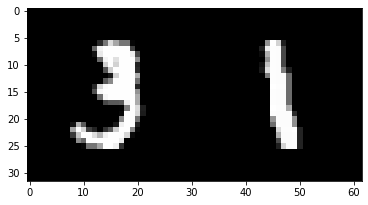

In [ ]:
img_1, label_1 = dataset[10]
img_2, label_2 = dataset[6]

print(f'Расстояние между классами по пикселям {label_1} и {label_2}')
print(torch.mean(torch.square(img_1 - img_2)).item())

grid = torchvision.utils.make_grid([img_1, img_2])
plt.imshow(grid.permute(1, 2, 0));

Расстояние между классами по пикселям 3 и 3
0.11974499374628067


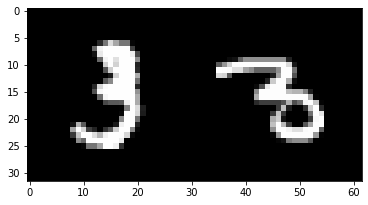

In [ ]:
img_3, label_3 = dataset[30]

print(f'Расстояние между классами по пикселям {label_1} и {label_3}')
print(torch.mean(torch.square(img_1 - img_3)).item())

grid = torchvision.utils.make_grid([img_1, img_3])
plt.imshow(grid.permute(1, 2, 0));

Чтобы получить расстояние между объектами одного класса меньше, чем между объектами другого класса, можем обучить модель для классификации и взять выход со слоя эмбеддинга и по ним считать расстояния.

In [ ]:
class TinyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4,
                               kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8,
                               kernel_size=3)
        self.fc1 = nn.Linear(in_features=200,
                             out_features=128)
        self.fc2 = nn.Linear(in_features=128,
                             out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.relu(x)
        x = x.reshape((-1, 200))
        emb = self.fc1(x)
        x = self.fc2(emb)
        return x, emb

In [ ]:
def train(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    for step, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        pred, _ = model(imgs)

        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f'Loss is {loss.item()}')

    return model

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True
)

In [ ]:
model = TinyModel(10)
model = train(model, dataloader)

Loss is 2.308760643005371
Loss is 0.4949835240840912
Loss is 0.22830426692962646


In [ ]:
model.to('cpu')
_, emb_1 = model(img_1[None])
_, emb_2 = model(img_2[None])
_, emb_3 = model(img_3[None])

In [ ]:
print(f'Расстояние между классами {label_1} и {label_2}')
print(torch.mean(torch.square(emb_1 - emb_2)).item())

print(f'Расстояние между классами {label_1} и {label_3}')
print(torch.mean(torch.square(emb_1 - emb_3)).item())

Расстояние между классами 3 и 1
0.8163442015647888
Расстояние между классами 3 и 3
0.4071192741394043


Теперь если вернемся к нашим оставленным задачам. Сейчас мы можем их решить используя полученную информацию. 

* Кто из людей в тренировочных данных изображен на новом фото?

Решается с помощью сравнения полученных точек в нашем n-мерном пространстве с помощью k ближайших соседей. 

* На двух новых фото один и тот же человек или нет?

Тут тот же подход.

* Даны 3 фото нового человека. Изображен ли он на еще одном фото?

Просто так же сравниваем новую точку с тремя данными.

Если будем обучать с обычным softmax loss, то сети будет достаточно просто разделить классы между собой. Другими словами, у каждого человека есть свое пространство, в которое должны попадать все вектора его лиц. Но есть проблема - расстояние (угол) между изображениями на границах близких классов может быть меньше, чем расстояние между некоторыми изображениями одного класса.

Можно добавить между этими пространствами некоторую пустую область. Теперь между нашими классами есть пустая область, и граничные изображения одного класса далеко до изображений других классов.

<img src='https://hsto.org/webt/kp/ic/vd/kpicvd1vebzshxykvcwuapx67q4.jpeg' width=500>


Обучать такую модель можно с помощью специальных функций потерь, к примеру, Triplet Loss или Contrastive loss.

В случае обучения метрики, мы заставляем сеть увеличивать расстояние между фотографиями разных людей и уменьшать его между фотографиями одного и того же человека. 


**Triplet loss** - это функция потерь, где базовый вход (якорь) сравнивается с позитивным входом и с негативным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются тройки.


**Contrastive loss** - это функция потерь, где базовый вход (якорь) сравнивается только с позитивным входом, либо только с негативнымным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются пары.


<img src='https://drive.google.com/uc?export=view&id=1PCtuC8wagk5sBtlym6ACH1HKRaEs-6Wm'>


Triplet Margin Loss вычисляет критерий для измерения триплетных потерь в моделях. С помощью этой функции потерь вы можете рассчитать потери при наличии входных тензоров x1, x2, x3, а также запаса со значением больше нуля.

Триплет состоит из a (anchors), p (положительные примеры) и n (отрицательные примеры).

Потеря Pytorch Triplet выражается как:

$$L(a,p,n) = max(d(a_i,p_i)- d(a_i, n_i) + margin, 0)$$

In [ ]:
anchor = torch.randn(1, 3, requires_grad=True)
positive = torch.randn(1, 3, requires_grad=True)
negative = torch.randn(1, 3, requires_grad=True)

triplet_margin_loss = nn.TripletMarginLoss(margin=1.0)
output = triplet_margin_loss(anchor, positive, negative)

print('anchor: ', anchor)
print('positive: ', positive)
print('negative: ', negative)
print('output: ', output)

anchor:  tensor([[-0.6414, -0.5485, -0.6162]], requires_grad=True)
positive:  tensor([[-1.3862,  1.0188, -0.4942]], requires_grad=True)
negative:  tensor([[0.2994, 2.7092, 0.5676]], requires_grad=True)
output:  tensor(0., grad_fn=<MeanBackward0>)


In [ ]:
torch.mean(torch.square(anchor - positive))

tensor(1.0087, grad_fn=<MeanBackward0>)

In [ ]:
torch.mean(torch.square(anchor - negative))

tensor(4.2998, grad_fn=<MeanBackward0>)

Примеры использования эмбеддингов:

<table>
<tr>
<td><img src='https://drive.google.com/uc?export=vies&id=1MgzghaC1HmVMZS0rAA8yblOfyoXNfJmg' width=400></td>
<td><img src='https://drive.google.com/uc?export=view&id=1obCDNWxFcccRcoQ19rBIVb4IOAk_bH50' width=300></td>
<td><img src='https://drive.google.com/uc?export=view&id=12GlZTtGFBUPgWDwi5G85R3-bvDRbSm2l'></td>
<tr>
</table>

Библиотека с функциями потерь для обучения моделей [Pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/)

Вопрос, Можно ли используя подобные представления получить не используя метки, т.е. как-то обойтись без классического обучения с учителем?

## 2. Unsupervised Learning. Обучение без учителя

Т.е. в данной задаче у нас есть просто данные (без меток) и есть алгоритмы, которые просто берут эти данные. И вместо того, что бы что-то предсказывать на этих данных, они выявляют некоторую структуру в этих данных. Они дают некоторую информацию о том, что в этих данных происходит.

### 2.1 Autoencoder

Пример подобных задач является автоэнкодер. Представьте, что у нас есть только фотографии без меток и мы хотим получить какую-то нейросеть, которая преобразовывает картинку в некий вектор, который описывает то, что происходит в картинке на более высоком уровне. 
Допустим, создадим нейросеть, которая на вход принимает картинку. И на выходе она тоже выдает картинку. И мы заставим нейросеть получать ту же самую картинку.


<img src='https://drive.google.com/uc?export=view&id=1GwfDua-4m7D3sW1eycPjr58YrRkyLNc0'>

Функция потерь будет очень простой L2:

$$L = ||x_{out} - x_{in}||^2$$

И что бы это не выглядело, что мы просто учим нейросеть выдавать ту же самую картинку что и на выходе - мы акцентируем внимание на внутреннем слое, который будет такого размера, что всю информацию о картинке туда не записать. И поэтому сети надо научиться как-то сжать эту информацию, так что бы она потом могла расжать ее наиболее эфективно. Для этого ей придется распознать на изображении определенные высокоуровневые фичи, что бы смочь потом реалистично их сгенерировать. Это внутренее представление картинки часто называют Latent Space. Грубо говоря, некоторая латентная (внутреняя, скрытая) информация, которую сеть должна научиться извлекать из картинки и составить о ней представление. 

**Зачем это может пригодиться?**

Мы можем например взять получившийся энкодер и присобачить после слоя Latent Space какой-нибудь слой классификации для обучения этого классификатора на задачу классификации. Т.е. используем это все как претрэйнинг. 

Допустим, у нас куча неразмеченных данных. И немного размеченных. И мы сначала обучаем наш энкодер на неразмеченных. А потом, уже добавив классификатор, обучаем на маленьком размеченном датасете.

Но если честно в таком виде автоэнкодеры работают так себе. Они не дают такого богатого представления, какого от них ожидается. Очень часто в таких моделях происходит overfitting. Получаемые энкодеры таким способом хорошо работают только для фиксированных точек в получающемся пространстве. Если мы хоть немного поменяем наш получившийся embedding, то наша модель выдаст ерунду.

И люди работали над разными подходами для решения этой проблемы. К этому перейдем попозже. А сейчас реализуем свой автоэнкодер на PyTorch. Обучать будем на MNIST.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Создадим класс Encoder, наследованный от torch.nn.Module.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

Создадим что-то похожее но теперь для декодера, главное, чтобы совпадала размерность выхода.



In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

Напишем класс Autoencoder, который соединяет экнкодер и декодер.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for step, (x, _) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat) ** 2).sum()
            loss.backward()
            opt.step()

            if step % 200 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]. Step [{step}/{len(data)}]. Loss is {loss.item():.2f}')
    return autoencoder

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
       torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
       batch_size=256,
       shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
%%time
autoencoder = train(autoencoder, data)

Epoch [1/20]. Step [0/235]. Loss is 46469.51
Epoch [1/20]. Step [200/235]. Loss is 10519.13
Epoch [2/20]. Step [0/235]. Loss is 10162.24
Epoch [2/20]. Step [200/235]. Loss is 9661.72
Epoch [3/20]. Step [0/235]. Loss is 9492.07
Epoch [3/20]. Step [200/235]. Loss is 9195.71
Epoch [4/20]. Step [0/235]. Loss is 9045.36
Epoch [4/20]. Step [200/235]. Loss is 9081.17
Epoch [5/20]. Step [0/235]. Loss is 9187.55
Epoch [5/20]. Step [200/235]. Loss is 9017.89
Epoch [6/20]. Step [0/235]. Loss is 8987.27
Epoch [6/20]. Step [200/235]. Loss is 8911.71
Epoch [7/20]. Step [0/235]. Loss is 8598.37
Epoch [7/20]. Step [200/235]. Loss is 8679.12
Epoch [8/20]. Step [0/235]. Loss is 8813.32
Epoch [8/20]. Step [200/235]. Loss is 8510.46
Epoch [9/20]. Step [0/235]. Loss is 8767.26
Epoch [9/20]. Step [200/235]. Loss is 8373.87
Epoch [10/20]. Step [0/235]. Loss is 8675.32
Epoch [10/20]. Step [200/235]. Loss is 8348.11
Epoch [11/20]. Step [0/235]. Loss is 8691.55
Epoch [11/20]. Step [200/235]. Loss is 8969.89
Epo

Можем посмотреть на скрытое пространство, которое состоит из двух размерностей. Также у нас есть метки классов всех точек, поэтому можем их раскрасить.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    plt.figure(figsize=(10, 8))
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Наше скрытое представление отнесло изображения из одного класса в один кластер.

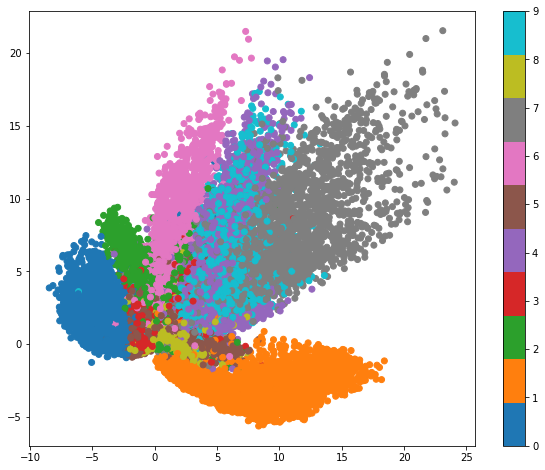

In [ ]:
plot_latent(autoencoder, data)

Можем ещё насэмплировать точек из скрытого пространства и посмотреть, как декодер их переводит в картинки.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

    plt.figure(figsize=(15, 6))
    plt.imshow(img, extent=[*r0, *r1])
    plt.axis('off')

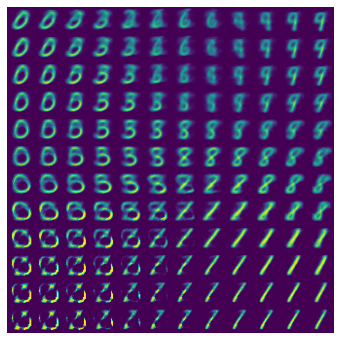

In [ ]:
plot_reconstructed(autoencoder)

Можем наблюдать, что реконструированные векторы выглядят как цифры, но есть проблемы, где непонятно, что за цифра написана. Эта как раз проблема переобучения и выколотых точек в пространстве, с такой архитектурой сети невозможно генерировать объекты.  
Потому что если попросим такой автоэнкодер сгенерировать изображение по вектору из скрытого пространства, а подобного вектора наша модель никогда не видела, то и выход сети может не иметь никакого смысла.

### 2.2 Variational Autoencoder (VAE)

Идея его следующая: 

Вот у нас есть некоторое заданное пространство Z, в котором у нас есть наше latent-представление. И мы хотим что бы энкодер и декодер научились генерировать и распаковывать точки из него не из выколотых точек, а покрыть это пространство наиболее плотно. Как мы это будем делать?

Наше внутреннее представление разобъем на две части. Вместо того, чтобы предсказывать один вектор или одну точку, мы будем предсказывать целый круг в этом пространстве (область пространства).


<img src='https://drive.google.com/uc?export=view&id=1VGNYx2067ZrNDrJF-9u_QUJ0ET8CA-mL'>

Для этого надо будет предсказать среднее и дисперсию: $$\mu,\sigma$$

Среднее будет соответствовать центру круга, а дисперсия - радиусу. 

И затем на вход декодеру возьмем случайную точку в этом предсказанном кружке по формуле:

$$\mu + n\sigma\\n ~ N(0,1)$$

И этот декодер должен будет по нему реконструировать ту же картинку.

И наш лосс будет состоять из двух частей. Первый - это то что декодер может восстановить для этой случайной точки картинку:

$$L_r = ||x_{out} - x_{in}||^2$$

А второй лосс, будет стимулировать наш энкодер не делать слишком маленькие круги, а то мы вернемся к ситуации когда у нас точки, а не круги:
    
$$L_{KL} = D_{KL}(\mu, \sigma||N(0,1)) = \sum_{j=0}^{N}({\sigma_j}^2 + {\mu_j}^2 - log{\sigma_j}^2 - 0.5)$$

Второй лосс говорит нам, что неплохо, что бы те сигма и мю что мы предсказываем были бы похожи на весь большой круг. И таким образом стимулируем, чтобы эти круги были как можно больше. Эта метрика близости распределений. Т.е. она маленькая когда распределения далеко друг от друга и большая, когда распределения одинаковы.

И в итоге мы эти два лосса складываем. 

Вот так примерно об вариационном автоэнкодере. У данного энкодера есть другая интерпретация на основе байесовских моделей. Он работает гораздо лучше. Но с этим предлагаю ознакомиться самим, если интересно:

[Оригинальная ссылка](https://arxiv.org/abs/1312.6114)  
[Ссылка которую следует читать вместо первой. Тут понятнее](https://arxiv.org/abs/1606.05908)  
[pytorch-статья](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed)

Чтобы реализовать вариационный автоэнкодер не нужно будет менять класс декодера, нужно только поменять класс энкодера выдавать два вектора - среднее и дисперсия, а затем использоваться эти статистики для сэмлирования вектора из скрытого пространства.

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Чтобы обучить вариационный автоэнкодер нужно добавить дополнительный лосс в обучающий алгоритм.

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for step, (x, _) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            l2_loss = ((x - x_hat) ** 2).sum()
            kl_loss = autoencoder.encoder.kl
            loss = l2_loss + kl_loss
            loss.backward()
            opt.step()

            if step % 200 == 0:
                print(f'Epoch [{epoch+1}/{epochs}]. Step [{step}/{len(data)}].', end=' ')
                print(f'Loss is {loss.item():.2f}. L2 loss is {l2_loss:.2f}. KL loss is {kl_loss:.2f}')

    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

Epoch [1/20]. Step [0/235]. Loss is 47570.57. L2 loss is 47320.50. KL loss is 250.08
Epoch [1/20]. Step [200/235]. Loss is 11784.67. L2 loss is 10838.17. KL loss is 946.50
Epoch [2/20]. Step [0/235]. Loss is 11852.47. L2 loss is 10910.26. KL loss is 942.22
Epoch [2/20]. Step [200/235]. Loss is 10999.40. L2 loss is 9979.71. KL loss is 1019.70
Epoch [3/20]. Step [0/235]. Loss is 11403.21. L2 loss is 10395.64. KL loss is 1007.57
Epoch [3/20]. Step [200/235]. Loss is 11400.53. L2 loss is 10382.29. KL loss is 1018.24
Epoch [4/20]. Step [0/235]. Loss is 10641.48. L2 loss is 9584.13. KL loss is 1057.35
Epoch [4/20]. Step [200/235]. Loss is 10892.81. L2 loss is 9819.55. KL loss is 1073.26
Epoch [5/20]. Step [0/235]. Loss is 10538.43. L2 loss is 9460.87. KL loss is 1077.56
Epoch [5/20]. Step [200/235]. Loss is 10312.77. L2 loss is 9160.61. KL loss is 1152.15
Epoch [6/20]. Step [0/235]. Loss is 10940.44. L2 loss is 9845.73. KL loss is 1094.72
Epoch [6/20]. Step [200/235]. Loss is 10564.04. L2 lo

Снова посмотрим на скрытое пространство, но уже на вариационном автоэнкодере.

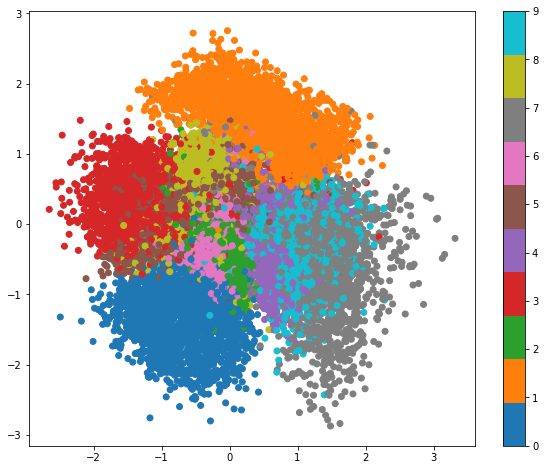

In [ ]:
plot_latent(vae, data)

В сравнении с автоэнкодром, VAE выдает более центрированные области классов и они более сжатые.  
И посмотрим на реконструированные цифры из векторов скрытого пространства.

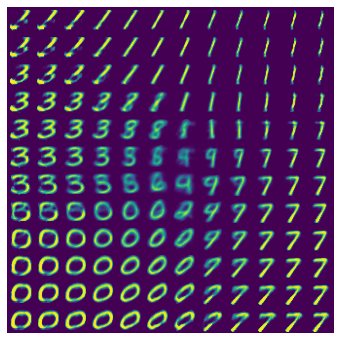

In [ ]:
plot_reconstructed(vae)

### 2.3 Интерполяции

Допустим у нас есть натренированный такой автоэнкодер. Что мы можем? Возьмем два лица. Представим их в latent-пространстве. Сравним их. И будем интерполировать: построим прямую через точки их представляющие, насэмплим точек по этой прямой и дадим нашему декодеру их декомпозировать. Получим примерно следующее:

<img src='https://drive.google.com/uc?export=view&id=1cib3j8vGN4ADkEUdJakg138KDJlfo-uu'>

https://arxiv.org/abs/1610.00291

Посмотрим на интерполяцию наших цифр, возьмем два вектора - начало и конец генерации.

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.figure(figsize=(10, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

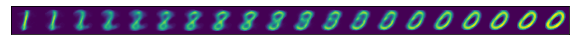

In [ ]:
interpolate(vae, x_1, x_2, n=20)

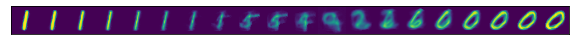

In [ ]:
interpolate(autoencoder, x_1, x_2, n=20)

И еще веселее смотреть не на набор изображений, а на анимацию переходов между реконструированными цифрами.

In [ ]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [ ]:
interpolate_gif(vae, "vae", x_1, x_2)

#### 2.3.1 Операции с latent space

Вот еще один способ как с этим можно играться: мы хотим найти в этом пространстве некое направление, которое соотвествует некоторому признаку. Например, мы хотим понять направление признака, что на лице есть улыбка.
Для этого мы возьмем например 50 лиц, на которых есть улыбка и на которых нет. И посмотрим на наше пространство. Те лица, на которых нет улыбки находятся в одной части пространства. Те, где есть улыбка находятся в другой части пространства. Мы можем усреднить эти лица (с улыбкой и без) и сможем подсчитать вектор в направлении между этими точками в нашем пространстве. И сможем увидить, что декодер начинает генерировать более улыбающиеся лица. 

Точно так же и сдругими признаками.


<img src='https://drive.google.com/uc?export=view&id=1188YE--Jzr-arKeMQDMF8kSgyI3AAMNp'>

Все хорошо, но стоит отметить, что все эти картинки получаются довольно размытыми. Почему это происходит?

Проблема в том, что наша функция по реконструкции - это L2. Т.е. она минимизирует расстояния. И в случае, когда мы не знаем, что предсказывать или в случае, когда много вариантов (бэкграунды везде разные) эффективнее всего предсказывать среднее. А среднее - это по определению размытие. И оказывается, что очень многие функции потерь этому подвержены. 

## 3. Generative Advarials Networks (GANs)

<img src='https://drive.google.com/uc?export=view&id=1ptYvhKSLTSufYKPESgaRhURF9GIWUey4'>

### 3.1 Архитектура

Другой подход в решению той же задачи - generative advarials networks.


Они же:

* генеративные соревновательные сети
* порождающие соперничающие сети
* порождающие соревнующиеся сети

Идея этих сетей состоит в том, что бы стравить между собой две нейросети, которые в процессе состязания учатся генерировать реалистичные картинки.

**Дискриминатор ($D$)**

Модель дискриминатора берет входные данные (реальные или сгенерированный) и предсказывает, к какому из этих двух классов принадлежат эти данные.

После процесса обучения модель дискриминатора отбрасывается, поскольку нас уже интересует только генерация данных.

**Генератор ($G$)**

Задача генератора - создавать «поддельные» изображения, похожие на те, что в обучающей выборке. 
Во время обучения генератор постоянно пытается обыграть дискриминатор, улучшая качество подделок.


**Подход**

У нас есть две сети. Первая называется Generator. Она на вход будет получать некоторый вектор шума z, который соотвествует нашему latent-пространству. И теперь генератор должен из этого шума преобразовать картинку.    
И у нас будет другая сеть Descriminator, которому на вход подается картинка. Она прогоняет ее через сверточную сеть и на выход дает только одно число. Такой бинарный классификатор. Таким образом эта нейросеть должна отличить реальную картинку от фальшивой.  
Т.е. Дискриминатору на вход будут приходить и фальшивые картинки от генератора и реальные картинки из датасета и наш процесс обучения будет проходить так, что дискриминатор пытается разобраться, реальная картинка или нет. А генератор будет учиться обманывать дискриминатор. И постепенно генератор будет генерировать все более реалистичные картинки. Дискриминатор будет все лучше и лучше отличать фальшивые от реальных. И в конце концов мы натренируем генератор до такого состояния, что дискриминатор больше не сможет распознать реальное или фальшивое изображение пришло на вход. В этом и состоит цель такого обучения.

<img src='https://drive.google.com/uc?export=view&id=1Dd2d_j05Dqh89DxuIds6nES6DhPiuw5Z'>

### 3.2 Процесс обучения

1. Возьмем наш батч из случайного шума. Т.е. сгенерируем m примеров векторов шума:

$$\left\{ z_1, ..., z_m\right\}$$

2. Сгенерируем m примеров из датасета, т.е. реальных картинок:

$$\left\{ x_1, ..., x_m\right\}$$

3. Прогоним эти m примеров шума через генератор и получим m сгенерированных картинок. 

4. И прогоним два батча через дискриминатор. При этом, у сгенерированных картинок будет отрицательный лэйбл. А у реальных - положительный лэйбл.

5. Мы проведем k шагов обучения дискриминатора, в которых он отличит реальные данные от нереальных. В начале обучения генератор генерирует по сути шум размера картинки. Поэтому дискриминатор очень быстро и удачно обучается различать реальные картинки от нереальных. 

Здесь мы обновляем веса Дискриминатора.

6. Обучаем Генератор. Мы опять генерируем m-батч случайных примеров z. Из них генерируем  батч картинок. Прогоняем их через Дискриминатор. Предположим, что Дискриминатор все их классифицирует как неправильные. А потом делаем шаг оптимизации Генератора, т.е. двигаемся в обратном направлении с замороженными весами Дискриминатора.

7. Затем мы возвращаемся в пункт 1. где снова обучаем Дискриминатор. Здесь Генератор уже чему-то обучился и Дискриминатору приходятся придумывать, как все-таки отличать лучше. И так прогоняем много и много раз. Наши Дискриминатор и Генератор таким образом сражаются, кто лучше. 

В итоге мы надеемся, что в конце получим Генератор, который получив на вход случайный шум, сможет генерировать правдоподобные картинки.

<h1><center>Часть 2. Практика</center></h1>

Рассмотрим реализацю самой первой статьи по GAN'ам на классическом датасете MNIST 

Generative Adversarial Nets [Ian J. Goodfellow](https://www.youtube.com/watch?v=Z6rxFNMGdn0) (2014) https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf  

## 0. Подготовка
Подключаем нужные модули и библиотеки

In [ ]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

Определим нужное нам устройство:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Загрузка датасета

Встроенными возможностями загружаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/):

In [ ]:
img_size = 28  # размер картинки, которую мы будет подавать в нейронные сети
channels = 1  # количество каналов в нашей картинке
batch_size = 16  # размер батча
img_shape = (channels, img_size, img_size)  # полный шейп нашей картинки

real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Вытащим часть сэмпла и посмотри что внутри:

img_shape = (1, 28, 28)
label shape = torch.Size([])
img_shape after squeeze = (28, 28)


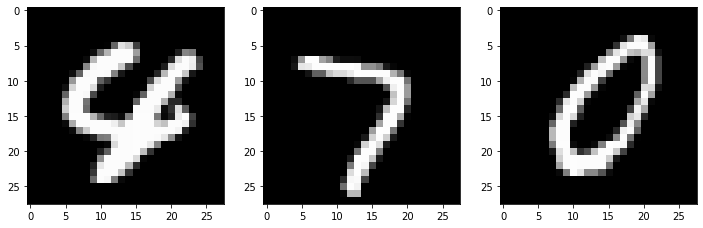

In [ ]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'label shape = {labels[0].shape}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray');

In [ ]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

### 2. Создание модели

#### 2.1 Генератор

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. Поскольку наши данные являются изображениями, преобразование z в пространство данных в конечном итоге означает создание изображения того же размера, что и обучающие изображения (то есть 1x28x28).

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.reshape(-1, *img_shape)
        return img

**Небольшое отступление**
Создание своих слоев. Если все правильно оформить, то созданный кастомный слой можно будет использовать внутри pytorch как обычный слой.

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [ ]:
layer = CustomLinearLayer(1, 2)
layer.weights, layer.bias

(Parameter containing:
 tensor([[-0.0046],
         [ 0.0033]], requires_grad=True), Parameter containing:
 tensor([0.0034, 0.0044], requires_grad=True))

nn.init.uniform_ Позволяет нам задать значения с помощью нормального распределения

#### 2.2 Дискриминатор

Как уже упоминалось, дискриминатор D представляет собой сеть двоичной классификации, который принимает изображение в качестве входных данных и выводит скалярную вероятность того, что входное изображение является реальным (в отличие от фальшивого). Здесь D принимает входное изображение размером 1x28x28

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.reshape(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# 3. Обучение

Инициализация:

In [ ]:
n_epochs = 20  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 19/20] [Batch 3250/3750]|[D loss: 0.6500122547149658] [G loss: 0.8147705793380737]


<Figure size 432x288 with 0 Axes>

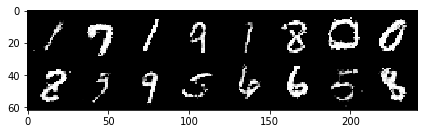

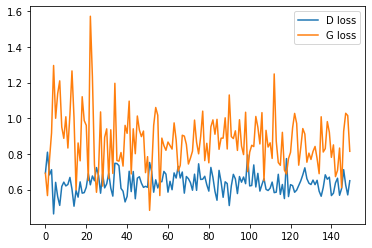

In [ ]:
import matplotlib.patches as mpatches


for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_imgs)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_imgs)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        

## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

## Дополнительные материалы

1. [Deep Learning на пальцах 8 - Metric Learning, Autoencoders, GANs
](https://youtu.be/ajEQ10s8XRg)
2. [Pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/)
3. [Зоопарк GAN'ов](https://github.com/hindupuravinash/the-gan-zoo)
4. [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)
5. [Deep Feature Consistent Variational Autoencoder](https://arxiv.org/abs/1610.00291)
6. [Оригинальная научная статья по GAN](https://arxiv.org/pdf/1710.07035.pdf)
7. [Stable Diffusion](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)
